# Working with relational databases in Python

In the last project I showed you how to import data from the web, load it into a DataFrame, and then conduct some exploratory data analysis.

At the beginning of the NFL season I created a [SQLite](https://www.sqlite.org/index.html) database to store player statistics to use in DraftKings as well as information about the players and their team. I chose to use SQLite because it's fast and simple. **This notebook** will introduce the following concepts:

- Using SQLAlchemy to create a database engine
- How to query  a relational database in Python
- How to store the results of a query to a Pandas DataFrame
- Using the context manager to open a connection

In [63]:
#Import necessary modules
from sqlalchemy import create_engine
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

os.chdir('C:\\Users\\bad31\\Desktop\\Fantasy\\Database') #Change working directory to the location of the .db file

### SQLAlchemy
I'm using [SQLAlchemy](https://www.sqlalchemy.org/) to create a database engine that will connect to my SQLite database - **DailyFantasy**. The create_engine function only takes one argument, the connection string:
`'sqlite:///[YourFileName].sqlite'`

In [64]:
#Create engine to connect to the SQLite database:engine
engine = create_engine('sqlite:///DailyFantasy.db')

#Save the database table names to a list:table_names
table_names= engine.table_names()

#Print the table names
table_names


['Performance', 'Projections', 'TeamSchedule', 'Teams', 'sqlite_sequence']

### Workflow of SQL querying

 - Import packages and functions
 - Create the database engine
 - Connect to the engine
 - Query the database
 - Save query results to a dataframe

These next few steps will show you how to  open a connection to the database engine and execute the **Hello World** of SQL statements: 
```*.sql
SELECT *
FROM 'table_name';
```


In [65]:
#Open the engine connection as con using the method connect() on the engine:con
con = engine.connect()

#Execute a query that selects ALL columns from the 'Teams' table:results
results = con.execute("SELECT * FROM Teams")

### Store the results of a query to a DataFrame

To turn our results object into a DataFrame, we apply the method fetchall() to *results* and save it as DataFrame using the `pd.DataFrame()` function.

In [66]:
#Save the results of the query to a DataFrame:df
df = pd.DataFrame(results.fetchall())

#Let's check out the first 5 rows of the DataFrame
df.head()

,0,1,2,3,4
0,ARI,Arizona Cardinals,Cardinals,NFC,W
1,ATL,Atlanta Falcons,Falcons,NFC,S
2,BAL,Baltimore Ravens,Ravens,AFC,N
3,BUF,Buffalo Bills,Bills,AFC,E
4,CAR,Carolina Panthers,Panthers,NFC,S


In [67]:
#The column names aren't quite correct. To fix this, you can set the DataFrame column names by executing the following
df.columns = results.keys()
df.head()

,TeamID,TeamName,ShortName,League,Division
0,ARI,Arizona Cardinals,Cardinals,NFC,W
1,ATL,Atlanta Falcons,Falcons,NFC,S
2,BAL,Baltimore Ravens,Ravens,AFC,N
3,BUF,Buffalo Bills,Bills,AFC,E
4,CAR,Carolina Panthers,Panthers,NFC,S


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 5 columns):
TeamID       32 non-null object
TeamName     32 non-null object
ShortName    32 non-null object
League       32 non-null object
Division     32 non-null object
dtypes: object(5)
memory usage: 1.3+ KB


### Example query - Comparing Actuals against Projected Output

This is a weekly report I run that shows actual points scored on DraftKings for each player compared to their RotoGrinders projections for points. Right now I'm only looking at positional players, and don't include Defense and Special Teams in my analysis.

In the future I'm going to add weather data to see if it helps in roster construction and understanding which players perform poorly when the snow and cold set in.

In [69]:
week_10_results = con.execute("""select Performance.FirstName || ' ' || Performance.LastName as PlayerName
                                        ,Teams.ShortName as Team
                                        ,Teams.League
                                        ,Performance.Position
                                        ,Projections.Points as ProjectedPoints
                                        ,Performance.PointsScored as ActualPoints
                                        ,ROUND(Performance.PointsScored - Projections.Points,1) as Variance
                                        ,case 
                                            when TeamSchedule.DayName = 'Sun' and TeamSchedule.GameTime <'5:00:00 PM' 
                                                then 'Main Slate'
                                            when TeamSchedule.DayName = 'Sun' and TeamSchedule.GameTime >='8:00:00 PM' 
                                                then 'Sunday Night'
                                            when TeamSchedule.DayName = 'Thu' 
                                                then 'Thurday Night'
                                            when TeamSchedule.DayName = 'Mon' 
                                                then 'Monday Night'
                                            else 'Review'
                                                end as 'GameSlate'
                                            
                                            from Performance
                                                inner join Projections 
                                                    on (Performance.PlayerID = Projections.PlayerID
                                                        and Performance.WeekID = Projections.WeekID)
                                                inner join Teams
                                                    on (Performance.TeamID = Teams.TeamID)
                                                inner join TeamSchedule
                                                    on (Performance.TeamID = TeamSchedule.TeamID
                                                        and Performance.WeekID = TeamSchedule.WeekID)

                                            where Performance.WeekID = 10;""")

In [70]:
week_10_df = pd.DataFrame(week_10_results.fetchall())
week_10_df.columns = week_10_results.keys()

In [71]:
print("\n Week 10 DraftKings Results - Positional Players")
week_10_df.head()


 Week 10 DraftKings Results - Positional Players


,PlayerName,Team,League,Position,ProjectedPoints,ActualPoints,Variance,GameSlate
0,Josh Adams,Eagles,NFC,RB,5.80,4.7,-1.1,Sunday Night
1,Nelson Agholor,Eagles,NFC,WR,9.99,13.3,3.3,Sunday Night
2,Keenan Allen,Chargers,AFC,WR,18.30,17.7,-0.6,Main Slate
3,Danny Amendola,Dolphins,AFC,WR,11.49,14.2,2.7,Main Slate
4,CJ Anderson,Panthers,NFC,RB,1.77,-0.1,-1.9,Thurday Night


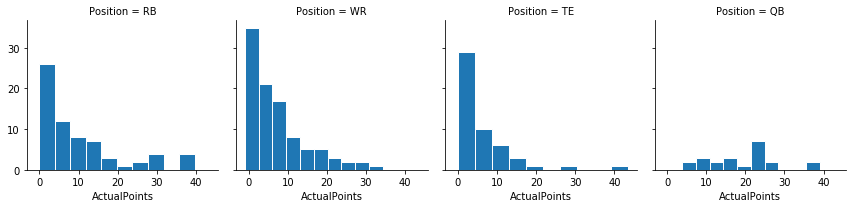

In [108]:
#Let's look at the distribution of actual points scored by position for Week 10
g = sns.FacetGrid(week_10_df, col="Position")
g = (g.map(plt.hist, "ActualPoints", edgecolor="w"))

In [109]:
#Subset the dataframe by each position and compute the mean number of points scored by slate
qb_df = week_10_df.loc[week_10_df['Position']=='QB'].groupby(by='GameSlate').describe()
rb_df = week_10_df.loc[week_10_df['Position']=='RB'].groupby(by='GameSlate').mean()
wr_df = week_10_df.loc[week_10_df['Position']=='TE'].groupby(by='GameSlate').mean()
te_df = week_10_df.loc[week_10_df['Position']=='TE'].groupby(by='GameSlate').mean()

In [110]:
qb_df

ActualPoints                                                     \
                     count      mean        std    min     25%    50%     75%   
GameSlate                                                                       
Main Slate            16.0  18.21875   9.295749   3.80   9.895  20.03  24.140   
Monday Night           2.0  15.81000   5.246732  12.10  13.955  15.81  17.665   
Sunday Night           2.0  23.40000   2.404163  21.70  22.550  23.40  24.250   
Thurday Night          2.0  27.27000  16.334167  15.72  21.495  27.27  33.045   

                     ProjectedPoints          ...                  Variance  \
                 max           count    mean  ...       75%    max    count   
GameSlate                                     ...                             
Main Slate     39.00            16.0  18.580  ...   19.7900  21.93     16.0   
Monday Night   19.52             2.0  17.830  ...   17.9400  18.05      2.0   
Sunday Night   25.10             2.0  19.475  ...   20.4575  21.44      2.0   
Thurday Night  38.82             2.0  21.290  ...   21.5550  21.82      2.0   

                                                                   
                 mean        std   min    25%   50%     75%   max  
GameSlate                                                          
Main Slate    -0.3625   8.137885 -10.3 -6.975  0.40   4.025  19.9  
Monday Night  -2.0000   4.949747  -5.5 -3.750 -2.00  -0.250   1.5  
Sunday Night   3.9500   0.353553   3.7  3.825  3.95   4.075   4.2  
Thurday Night  6.0000  17.111984  -6.1 -0.050  6.00  12.050  18.1  

[4 rows x 24 columns]

In [111]:
rb_df

,ProjectedPoints,ActualPoints,Variance
GameSlate,,,
Main Slate,8.944792,10.143750,1.195833
Monday Night,8.855000,8.983333,0.116667
Sunday Night,8.111667,9.300000,1.200000
Thurday Night,7.760000,9.928571,2.157143


In [112]:
wr_df

,ProjectedPoints,ActualPoints,Variance
GameSlate,,,
Main Slate,5.553235,5.526471,-0.020588
Monday Night,5.423333,4.583333,-0.833333
Sunday Night,4.952857,7.414286,2.471429
Thurday Night,6.910000,7.550000,0.650000


In [113]:
te_df

,ProjectedPoints,ActualPoints,Variance
GameSlate,,,
Main Slate,5.553235,5.526471,-0.020588
Monday Night,5.423333,4.583333,-0.833333
Sunday Night,4.952857,7.414286,2.471429
Thurday Night,6.910000,7.550000,0.650000
